# Classificação multinomial

### Índice <a name="topo"></a>
- 1. [Introdução](#1)
    - 1.1 [Carregar a base do exemplo](#1.1)
    - 1.2 [Dados faltantes](#1.2)
    - 1.3 [Descritiva inicial](#1.3)
- 2. [Preenchimento de dados faltantes](#2)
    - 2.1 [2.1 Análise descritiva: vale a pena preencher ```sex``` com modelo?](#2.1)
    - 2.2 [2.2 Modelo de preenchimento](#2.2)
- 3. [Classificação multinomial](#3)
    - 3.1 [A árvore](#3.1)
    - 3.2 [Pós-poda](#3.2)
    - 3.3 [A árvore](#3.3)
    - 3.4 [Avaliação do resultado](#3.4)

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

matplotlib.use('agg') 

### 1. Introdução <a name="1"></a>
[Voltar para o índice](#topo)

#### 1.1 Carregando a base de exemplo<a name="1.1"></a>
[Voltar para o índice](#topo)

Nesta aula vamos trabalhar com a base *penguins*. Essa base pode ser carregada com a ajuda do pacote ```seaborn``` conforme abaixo. Já trabalhamos algumas vezes com ela, ela traz dados biométricos de três raças de pinguins. A nossa tarefa vai ser escrever um algoritmo que classifique o pinguim em uma dessas espécies com base nas características biométricas dele.

In [7]:
pg = sns.load_dataset('penguins')
pg.shape

(344, 7)

In [8]:
pg

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


#### 1.2 Dados faltantes<a name="1.2"></a>
[Voltar para o índice](#topo)  

Vamos trabalhar com o *scikitlearn*, o que significa que não podemos ter dados *missing* nem em formato *não numérico* na base. Conforme a análise abaixo, podemos ver que há dois valores missing em quatro variáveis, e a variável ```sex``` possui 11 valores não preenchidos.

In [9]:
pg.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

#### 1.3 Descritiva inicial<a name="1.3"></a>
[Voltar para o índice](#topo)  

Vamos fazer uma matriz de dispersão (*scatterplot matrix*) para visualizar quão promissora é a classificação das raças de pinguim de acordo com as variáveis biométricas.

In [10]:
sns.pairplot(pg, hue='species');

Vamos nos certificar de que essas duas observações são o mesmo registro. Se for o caso, vai ter baixo impacto no nosso algoritmo elimina-los.

In [11]:
pg[pg['bill_depth_mm'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


Sim, são as mesmas, então eliminar estas observações implica em perder apenas duas observações (e bem incompletas por sinal).

In [12]:
pg1 = pg[~pg['bill_depth_mm'].isna()].copy()

### 2 Preenchimento de dados faltantes<a name="2"></a>
[Voltar para o índice](#topo)  

Para a variável ```sex```, temos mais 9 registros com dados faltantes. Claro que em se tratando de análise de dados, podemos ter inúmeras alternativas, mas eu vejo aqui três razoáveis com prós e contras:

- Eliminar a variável ```sex```. Essa alternativa pode significar abrir mão de uma fonte de varição importante que deve ajdar a classificar os indivíduos em suas respectivas classes.
- Eliminar os 9 registros faltantes: parece uma solução ok, mas já vamos para 11 registros eliminados de 344.
- Fazer imputação de dados: Isso significa tentar "adivinhar" qual o valor para a variável faltante para não perder o registro. Se fizermos isso mal, podemos introduzir ruído na base, por outro lado, recuperamos esses registros.

A terceira opção parece mais interessante. Agora... que método podemos utilizar? 
- Podemos fazer imputação pela moda - utilizar o valor que mais aparece na base.
- Imputação aleatória: simplemente sortear um valor conforme a distribuição observada
- Ou ainda, a solução que vamos adotar, fazer uma "imputação por árvore":
    - Vamos construir uma árvore de decisão para classificar o sexo dos pinguins dadas as demais variáveis
    - Em seguida vamos usar esta árvore para classificar os valores faltantes.

Se a nossa árvore for boa, vamos cometer um erro pequeno, e em todo caso, vamos "salvar" as observações com dados faltantes. Como contra, eu apontaria o trabalho de se construir esta árvore. No caso, como tudo é um aprendizado, vamos arregaçar as mangas :)

#### 2.1 Análise descritiva: vale a pena preencher ```sex``` com modelo?<a name="2.1"></a>
[Voltar para o índice](#topo)  

Em primeiro lugar, precisamos tentar entender se "vale a pena" fazer essa árvore. Intuitivamente, entendemos que os pinguins devem ter características bem diferentes no macho e na fêmea, a começar do peso. Vamos ver se os dados indicam isto:

In [13]:
sns.set_theme(style="ticks")

sns.boxplot(data=pg, x='species', hue="sex", y='bill_length_mm')

<Axes: xlabel='body_mass_g', ylabel='Density'>

Pelo visto sim, machos e fêmeas possuem medidas bem diferentes dada a espécie, principalmente.

#### 2.2 Modelo de preenchimento<a name="2.2"></a>
[Voltar para o índice](#topo)  

Vamos então para o modelo de imputação de dados. O primeiro passo é **preparar a base para classificar sexo**. Não vamos perder o objetivo de vista: agora queremos fazer um modelo para prever sexo, para imputar os valores faltantes. Vamos lá:

- Vamos retirar a variável ```sex``` da base
- Utilizar o ```get_dummies()``` para criar as variáveis dummy de ```species``` e ```island```
- Dividir a base em treino e teste
- Fazer a pós poda pelo ccp-alpha
- Classificar a base original para não perder as 9 observações

Sim, dá um trabalhinho, mas com o tempo isso tudo vai ficando mais automático ;)

Pois é, o nosso objetivo principal aqui é **aprender**. Caso contrário, seria absolutamente legítimo você decidir não fazer isto porque acha que não vale o custo vs benefício - aliás, esse é um julgamento muito útil para o cientista de dados ;)


##### Eliminando *missings* para a construção do modelo

In [14]:
pg2 = pg1[~pg1['sex'].isna()]
pg2.shape

(333, 7)

In [15]:
pg2.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

##### Criando *dummies* e separando bases de treino e teste

In [16]:
y0 = pg2.sex
X0 = pd.get_dummies(pg2.drop(columns = ['sex']), drop_first=True)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0)
X0.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,False,False,False,True
1,39.5,17.4,186.0,3800.0,False,False,False,True
2,40.3,18.0,195.0,3250.0,False,False,False,True
4,36.7,19.3,193.0,3450.0,False,False,False,True
5,39.3,20.6,190.0,3650.0,False,False,False,True


##### Construindo a árvore para classificar ```sex```
A célula abaixo monta a árvore, treina "deixando ela ser feliz" (sem limite de profundidade, número de observações ou complexidade). Também salva os *ccp alpahs* para fazermos a pós poda.

In [17]:
clf0 = DecisionTreeClassifier(random_state=42)
path = clf0.cost_complexity_pruning_path(X0_train, y0_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

##### Realiza a pós poda
Sobre a árvore acima, que é super complexa, vamos obter árvores derivadas e menos complexas seguindo o caminho indicado pelo custo de complexidade (o *ccp alpha*). Para cada árvore derivada, vamos avaliar a métrica de desempenho (no caso, a acurácia), e escolher a melhor árvore para fazer a imputação. 

In [18]:
clfs0 = []
for ccp_alpha in ccp_alphas:
    clf0 = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X0_train, y0_train)
    clfs0.append(clf0)

Vamos montar abaixo um gráfico que já vimos na aula de árvores binárias: para cada poda indicada pelo *ccp*, colocamos a métrica de desempenho da árvore na base de desenvolvimento e na base de testes.

In [19]:
train_scores = [clf0.score(X0_train, y0_train) for clf0 in clfs0]
test_scores  = [clf0.score(X0_test, y0_test)   for clf0 in clfs0]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

C:\Users\earap\AppData\Local\Temp\ipykernel_12512\2217188640.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Pronto. Abaixo tem uma "firula": Eu quero a melhor árvore, sim, mas se houverem empates, a que tenha a menor complexidade. Isso significa que eu quero pegar a maior métrica de desempenho no objeto ```test_scores```, mas se houver empates, queremos a primeira ocorrência desse máximo **da direita para a esquerda**.

Esse é um ótimo quebra cabeças de Python :) Abaixo temos um código bem pythonico que resolve isso.

In [20]:
ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs0[ind_melhor_arvore]

##### Substituindo os missings

Agora que fizemos a árvore para a variável ```sex```, vamos utilizar esta regra para substituir os valores missing na base original. Aí você pode me perguntar: "Por quê não fazemos para as outras 4 variávels?" E eu respondo com outra pergunta: "Séro? Você acha mesmo que vale a pena por 2 observações e sem ter muito com o que prever? Boa sorte então, pode fazer!" Repito: sempre vale refletir se vale o esforço de se construir um modelo.

In [21]:
# Seleciona as variáveis a serem substituídas
prever = pd.get_dummies(pg1.drop(columns = ['sex']), drop_first=True)
prever_sex = prever[pg1['sex'].isna()]

#faz a classificação conforme a árvore
inputação_sex = melhor_arvore.predict(prever_sex)
inputação_sex

array(['Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Female'], dtype=object)

In [22]:
# Faz a substituição propriamente dita
pg1.loc[pg1['sex'].isna(), 'sex'] = inputação_sex

print(pg1.shape)
pg1.isna().sum()

(342, 7)


species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Vamos salvar esta base de dados tratada, para uso futuro.

In [23]:
pg1.to_csv('pg1.csv', index=False)

### 3. Classificação multinomial<a name="3"></a>
[Voltar para o índice](#topo)  

Pronto, agora sim vamos para o tema principal: construir um algoritmo que classifique a **espécie** do pinguim em uma das três que aparecem na base de dados. A mecânica aqui é MUITO parecida com a classificação binária, basta utilizarmos generalizações das funções de impureza que comportem mais de duas classes e pronto: podemos usar o mesmo algoritmo.

Vamos seguir aqui passos bem parecidos:
- Tratar *missings* (acabamos de fazer isso)
- Criar *dummies*
- Construir a árvore (e deixa-la "ser feliz")
- Realizar a pós-poda e obter a árvore "ótima"

In [24]:
pg1.shape

(342, 7)

In [25]:
X = pd.get_dummies(pg1.drop(columns = ['species', 'island']), drop_first=True)
y = pg1['species']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
y_train.value_counts()

species
Adelie       119
Gentoo        88
Chinstrap     49
Name: count, dtype: int64

#### 3.1 A árvore<a name="3.1"></a>
[Voltar para o índice](#topo)

A árvore é bem semelhante à que já conhecemos, mas com mais de uma alternativa de resposta.

In [27]:
clf = DecisionTreeClassifier(random_state=2360873, max_depth=3).fit(X_train, y_train)

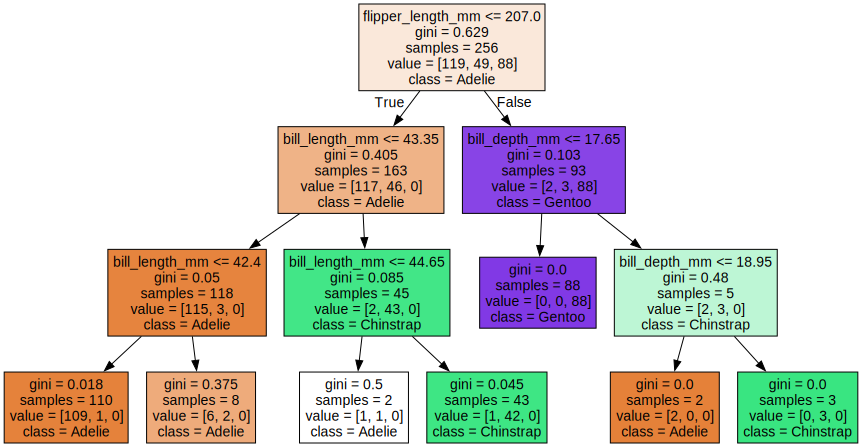

In [28]:
import graphviz
from sklearn.tree import export_graphviz
# DOT data
dot_data = export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['Adelie', 'Chinstrap', 'Gentoo'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

# Decision Tree Classifier from scikit-learn sklearn visualized with graphviz in Python

Avaliando a árvore completa

#### 3.2 Pós-poda<a name="3.2"></a>
[Voltar para o índice](#topo)  

Essa etapa é bem parecida com o que já fizemos. Vamos observar os "caminhos de poda" da árvore "grande", avaliar uma métrica de qualidade do modelo na base de testes, e selecionar a melhor.

In [29]:
caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, path.impurities

In [30]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

In [31]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

C:\Users\earap\AppData\Local\Temp\ipykernel_12512\2549957528.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


#### 3.3 Selecionando a melhor árvore<a name="3.3"></a>
[Voltar para o índice](#topo)  

Vamos pegar a melhor árvore utilizando a mesma lógica da árvore que usamos para preencher os registros faltantes na variável ```sex```.

In [36]:
ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]
melhor_arvore

DecisionTreeClassifier(random_state=2360873)

#### 3.4 Avaliando o resultado<a name="3.3"></a>
[Voltar para o índice](#topo)  

Agora vamos avaliar o resultado da nossa classificação utilizanod a acrurácia, na base de testes. Para um visual um pouco melhor, vamos utilizar a matriz de confusão.

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fazer previsões com o modelo
y_pred = melhor_arvore.predict(X_test)

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

In [41]:
# Exibir a matriz de confusão
print("Matriz de Confusão:")
print(cm)

# Plotar a matriz de confusão (opcional)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=melhor_arvore.classes_)
disp.plot()
plt.savefig('confusion_matrix.png')  # Salva o gráfico em um arquivo
plt.close()

Matriz de Confusão:
[[31  1  0]
 [ 0 19  0]
 [ 0  2 33]]


Sensacional esse resultado não? A taxa de acertos é impressionante! Até era de se esperar algo bom pela análise descritiva.

Mas, para refletir, o gancho para a próxima aula:

Será que "demos sorte" de a base de testes ter esse desempenho?  
Com outra base teriamos o mesmo desempenho?  
Como podemos obter uma métrica mais "confiável" do desempenho desse algoritmo?